# Imports

In [1]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Optional

# Constants

In [2]:
LOG_DIR: str = "./artifacts/hp_search/logs"
CONFIG_DIR: str = "./artifacts/hp_search/configs"
MODEL_SIZES: List[str] = ["30M", "98M"]

# Experiment

In [3]:
model_df = pd.DataFrame()
model_df["n_heads"] = [2, 4]
model_df["d_head"] = 128
model_df["d_model"] = model_df["n_heads"] * model_df["d_head"]
model_df["d_ffn"] = (model_df["d_model"] * 2.5).astype(int)
model_df["n_blocks"] = 32
model_df["name"] = ["30M", "98M"]
model_df["n_steps"] = [2284, 1862]
model_df = model_df.set_index("name")
model_df

,n_heads,d_head,d_model,d_ffn,n_blocks,n_steps
name,,,,,,
30M,2,128,256,640,32,2284
98M,4,128,512,1280,32,1862


# Helper functions

In [4]:
def extract_loss(log_file: str) -> Optional[float]:
    """Extracts the loss value from a log file."""
    try:
        with open(log_file, "r") as file:
            for line in file:
                if "Avg Eval Loss" in line:
                    return float(line.split()[-1])
    except FileNotFoundError:
        print(f"Warning: Log file not found: {log_file}")
    return None  # Return None if no loss value is found

def load_hyperparameters(config_file: str) -> Dict[str, float]:
    """Loads and extracts relevant hyperparameters from a YAML file."""
    try:
        with open(config_file, "r") as file:
            params = yaml.safe_load(file)

        model_params = params["trainer"]["init"]["model"]
        schedulers = params["trainer"]["init"]["schedulers"][0]["SequentialLR"]["schedulers"][0]["LinearLR"]

        return {
            "lr": float(schedulers["end_learning_rate"]),
            "initializer_range": float(model_params["initializer_range"]),
            "embeddings_scale": float(model_params["embeddings_scale"]),
            "attention_logits_scale": float(model_params["attention_logits_scale"]),
            "output_logits_scale": float(model_params["output_logits_scale"]),
        }
    except (FileNotFoundError, KeyError) as e:
        print(f"Error loading hyperparameters from {config_file}: {e}")
        return {}

def collect_hparams(model_size: str, batch_size: int, indices: List[int]) -> pd.DataFrame:
    """Collects hyperparameters and loss values for a given model size and set of trials."""
    hparams_list: List[Dict[str, float | int | None]] = []

    for i in indices:
        log_path = f"{LOG_DIR}/eval_{model_size}_hp{i:03}_bs{batch_size}.log"
        config_path = f"{CONFIG_DIR}/params_{model_size}_hp{i:03}_bs{batch_size}.yaml"

        loss_value = extract_loss(log_path)
        hparam = load_hyperparameters(config_path)
        if not hparam:  # Skip if loading failed
            continue

        hparam["loss"] = loss_value
        hparam["trial"] = i  # Add trial number for reference

        hparams_list.append(hparam)

    return pd.DataFrame(hparams_list).set_index("trial").sort_values(by="loss", ascending=True)

# Download artifacts

In [5]:
# run this once to download artifacts
# !mkdir artifacts
# !gcloud storage cp -r gs://cellarium-scratch/cellariumgpt-artifacts/training/hp_search artifacts/

# Load results

In [6]:
BATCH_SIZE_30M: int = 64
TRIALS_30M: List[int] = list(range(75))  # All 75 trials
df_30M: pd.DataFrame = collect_hparams("30M", BATCH_SIZE_30M, TRIALS_30M)

df_30M.head()

,lr,initializer_range,embeddings_scale,attention_logits_scale,output_logits_scale,loss
trial,,,,,,
24,0.002314,0.105706,7.661375,0.674693,2.997561,0.406286
18,0.000503,0.092781,3.361314,2.679735,2.330882,0.411174
64,0.000398,0.009901,7.050047,14.808042,10.510633,0.411859
58,0.000609,0.004342,7.307102,13.471671,16.680457,0.413343
8,0.000384,0.062964,3.201427,8.575146,0.801007,0.413763


Learning rate for trial 024 is too high. Let's choose trial 064 for model training.

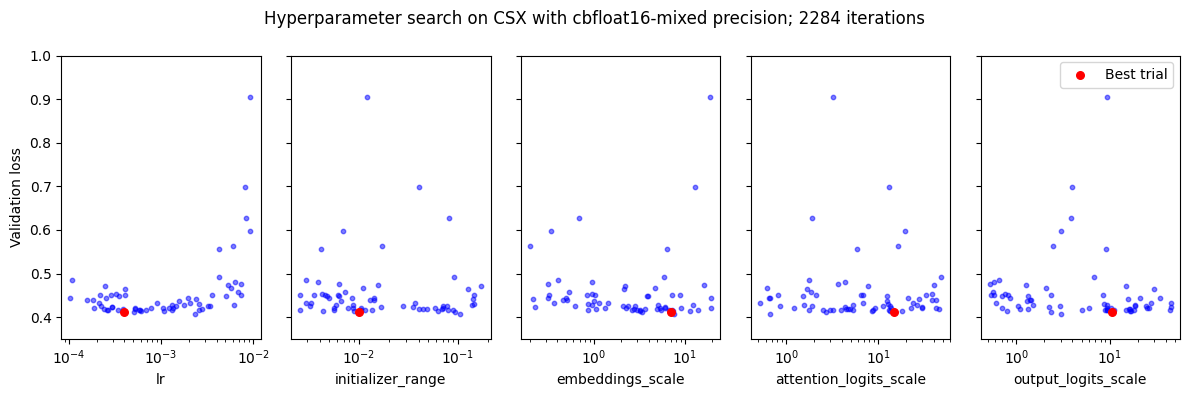

In [7]:
# Filter out "loss" column for plotting
hyperparams = [col for col in df_30M.columns if col != "loss"]
CHOSEC_TRIAL = 64

# Create figure and subplots
plt.figure(figsize=(12, 4))

for i, col in enumerate(hyperparams, start=1):
    plt.subplot(1, len(hyperparams), i)
    plt.scatter(df_30M[col], df_30M["loss"], s=10, color="blue", alpha=0.5)
    plt.scatter(df_30M.loc[CHOSEC_TRIAL, col], df_30M.loc[CHOSEC_TRIAL, "loss"], s=30, color="red", label="Best trial")
    plt.xscale("log")
    plt.xlabel(col)
    plt.ylim((0.35, 1.0))
    
    # Label only the first subplot's y-axis
    if i == 1:
        plt.ylabel("Validation loss")
    else:
        plt.gca().axes.yaxis.set_ticklabels([])

    # Add legend to the last subplot
    if i == len(hyperparams):
        plt.legend()

plt.suptitle("Hyperparameter search on CSX with cbfloat16-mixed precision; 2284 iterations")
plt.tight_layout()
plt.show()

Verify that trial 64 is still at the top for the 98M model.

In [8]:
BATCH_SIZE_98M: int = 256
TRIALS_98M: List[int] = [8, 18, 24, 58, 64]  # Specific trials
df_98M: pd.DataFrame = collect_hparams("98M", BATCH_SIZE_98M, TRIALS_98M)
df_98M.head()

,lr,initializer_range,embeddings_scale,attention_logits_scale,output_logits_scale,loss
trial,,,,,,
24,0.002314,0.105706,7.661375,0.674693,2.997561,0.360489
64,0.000398,0.009901,7.050047,14.808042,10.510633,0.366403
58,0.000609,0.004342,7.307102,13.471671,16.680457,0.371814
18,0.000503,0.092781,3.361314,2.679735,2.330882,0.373037
8,0.000384,0.062964,3.201427,8.575146,0.801007,0.373448
